# Slow is smooth, smooth is fast - A data driven mini-study of typing speed with MonkeyType

## Introduction

When I started taking programming seriously (~ 3 years ago), I was not a great programmer. Forget that, I wasn't even a good typist. I remember once it took me a full 10 minutes to find my backslash key to type "/n". In 2022 I decided that this had to change. I started doing typing practice and typing tests. Over the course of a year I improved from 40 words per minute while staring at the keyboard to 70 words per minute, typed with my head looking at the computer screen in front of me. But that was it. I had hit a limit, and no matter how much harder I tried, I felt I couldn't consistently pass that limit of 80 wpm.

That is, until 8 months ago when I watched some youtube videos which reccomended that I type slower and focus on accuracy. I thought this was interesting because it drew a parallel to another area of my life: the guitar.

When you have to learn a particularly hard or fast lick on the guitar, the general consensus is that the best way to practice it after you understand the general pattern, is to play the lick slowly and __perfectly__. The reasoning behind this is that playing it perfectly and consistently engrains a much more *exact* pattern into your muscle memory than faster, more uncontrolled practice. This results in far better playing in the long run. My theory was that typing, being a similar patterned movement of the fingers, is probably similar.

I decided to start practicing more intentionally, and start focusing more on accuracy, and over the course of those 8 months I improved massively going from an average of ~75 words per minute to my current average of 96 words per minute (and climbing). 

Recently, I discovered that MonkeyType, one of the websites that I use to test and practice typing, has a feature which allows you to download data from all typing tests on your account. Being a Data Analyst, I was intrigued and decided to do a little digging to see exactly how the idea of "slow is smooth, smooth is fast" applied to typing. I came into this analysis with 2 questions:

* When looking at short term would having the "all out" as-fast-as-you-can mindset work better on the scale of individual tests in the short term while screwing up long term progress? Or would it show short term losses as well?

* If I decide mid-way through a test to abandon it and try again with another test, will the natural selection of tests make my recorded wpm unreasonably high and if so, will that negatively affect my long-term growth?

As the nature of the data (timeframe, amount, and sparsity) and is revealed, these questions changed, but these were the types of questions I started out with

## Geting the data

The data provided by MonkeyType is given in the form of a .csv file. I downloaded my MonkeyType history into my repo and started studying up on the data structure

In [24]:
import config
import pandas as pd
from icecream import ic
import seaborn as sns

In [25]:
data_in = pd.read_csv(config.CSV_INPUT_FILEPATH())
data_in.columns

Index(['_id', 'isPb', 'wpm', 'acc', 'rawWpm', 'consistency', 'charStats',
       'mode', 'mode2', 'quoteLength', 'restartCount', 'testDuration',
       'afkDuration', 'incompleteTestSeconds', 'punctuation', 'numbers',
       'language', 'funbox', 'difficulty', 'lazyMode', 'blindMode',
       'bailedOut', 'tags', 'timestamp'],
      dtype='object')

## MonkeyType Data Structure
The following is a summary of the basic statistics I will use that are included for each test (each record)

* wpm (words per minute) - total amount of characters in the correctly typed words (including spaces), divided by 5 and normalised to 60 seconds.
> <em><strong>Analyst Note:</strong> The reason for this seemingly odd and out of the way calculation method is that if we were to use a literal words-per-minute measurement, then tests with longer words would be rated with slower speeds. Calculating this way means we get an approximation of the typers speed relative to the average english corpus (The average length of an english word is ~4.7 letters) </em>

* raw wpm - calculated just like wpm, but also includes incorrect words.

* acc - percentage of correctly pressed keys.

* char - correct characters / incorrect characters. Calculated after the test has ended.

> <em><strong>Analyst Note:</strong> This statistic, during initial filtering, is split into 3 seperate columns titled "Missed", "Extra", and "Incorrect"</em>

* consistency - based on the variance of your raw wpm. Closer to 100% is more consistent. Calculated using the coefficient of variation of raw wpm and mapped onto a scale from 0 to 100.


The following code uses a function I wrote in eda.py to automatically load and initally filter the input data (this process will be different as I maintain the data collection system).
The graphs will give you a good idea of what the filter does. 
   

---------------------------------------------------------------------------------------

### Graphs - Before and after initial filtering:
> <em><strong>Note: </strong> For the graphs which are wpm across index, and index coming from the data is backwards time-wise. That is why it appears that I am gradually getting really bad at typing</em>

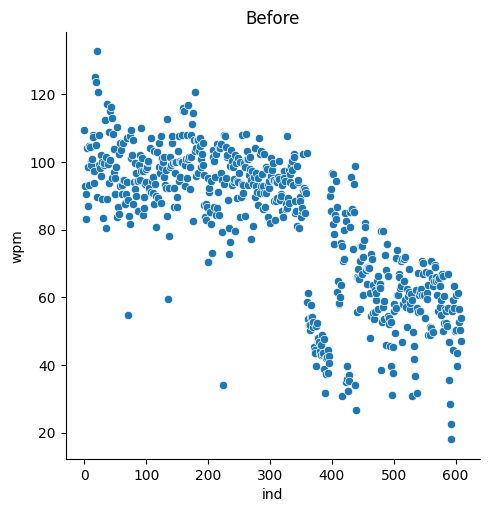

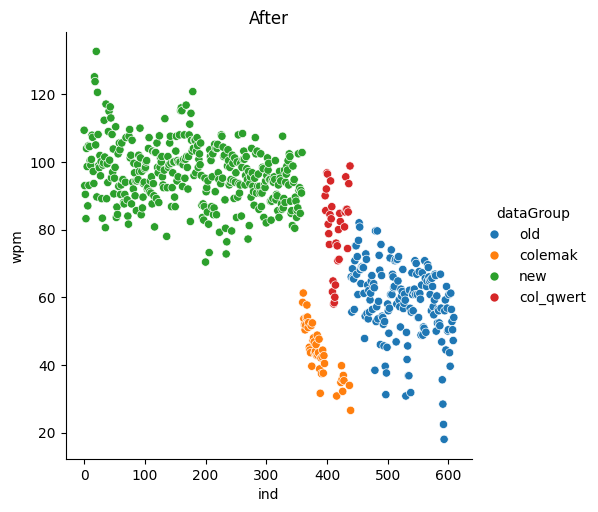

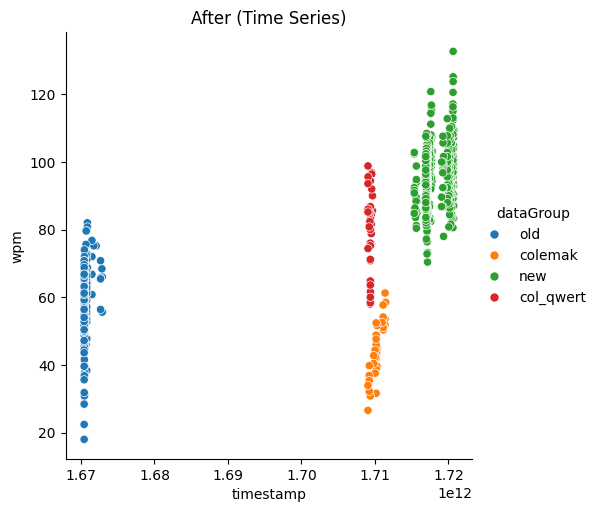

In [26]:
from eda import *
from sklearn.linear_model import LinearRegression

data_out = filt(data_in,plot=True)

sns.relplot(data=data_out,x="timestamp",y="wpm", hue = data_out.dataGroup).set(title = "After (Time Series)")


## Graph Key
* New (Green): Recent and relatively consistent attempts at improving my typing speed
> <em><strong>Note: </strong> This will be the only data we analyze for the time being because it is the largest quantity with the shortest time period and works well to isolate patterns which exist in the short term </em>
    
* Old (Blue): My earliest days of typing practice
    
* Outliers (Hidden): these were usually either instances of me leaving the computer in the middle of a test or purposely trying something new (e.g. one handed typing) just for kicks
    
* Colemak (Orange): The records typed with colemak during the period where I was using Monkeytype to learn the Colemak layout (I dropped it because it wasnt intuitive with vim)

* Colemak Qwerty (Red): The records typed with qwerty during the period where I was using Monkeytype to learn the Colemak layout

## Analysis
 Now that the data is loaded and categorized, we can begin the analysis. There are two goals of this analysis: two questions to answer and two hypotheses for each one. 

### Questions and Hypotheses
* Question: will your typing speed be better if you move your fingers as fast as possible, correcting any mistakes as you go, or will it be better if you move slower in an attempt to improve accuraccy
> Hypothesis: While the general consensus is that slowing your typing speed is better for long-term development and improvement (just like the guitar as I previously mentioned), moving your fingers faster will be better in the short term.

* Q: What is the effect on typing speed of re-trying tests? Monkeytype has a feature where you can elect at any point during the test to cancel your test and start a new one with a simple shortcut (\<tab>\<enter>)
> Hypothesis: typing speed will appear to be faster in the short term, but long term results will show that improvement will slow

Unfortunately we do not have a very diverse dataset or a long time span of clean data to search. This means we cannot look at long term typing improvement, but what we can do is test the short term selection bias itself is a problem.

In the next line, we are filtering to only new data done in the normal typing mode (as opposed to quotes mode), with no time spent AFK (away from keyboard). This will be the most representative subset of the data. 

In [27]:
data = data_out.where((data_out.dataGroup == "new") & (data_out.afkDuration == 0) & (data_out.quoteLength == -1)) #Filtering to only the newest, most representative data

In [28]:
data.describe()

,wpm,acc,rawWpm,consistency,quoteLength,restartCount,testDuration,afkDuration,incompleteTestSeconds,tags,timestamp,ind
count,300.000000,300.000000,300.000000,300.000000,300.0,300.000000,300.000000,300.0,300.000000,0.0,3.000000e+02,300.000000
mean,95.794033,95.583667,97.724400,74.678833,-1.0,3.720000,28.345767,0.0,16.741533,NaN,1.717951e+12,206.113333
std,8.097874,2.312025,8.126784,5.156587,0.0,5.915933,5.120227,0.0,31.690232,NaN,1.477741e+09,88.834297
min,72.790000,86.360000,72.790000,57.480000,-1.0,0.000000,15.000000,0.0,0.000000,NaN,1.715354e+12,50.000000
25%,90.390000,94.240000,92.397500,71.040000,-1.0,0.000000,30.000000,0.0,0.000000,NaN,1.716997e+12,128.750000
50%,95.580000,95.975000,97.780000,74.785000,-1.0,2.000000,30.000000,0.0,5.910000,NaN,1.717144e+12,206.500000
75%,101.580000,97.132500,102.892500,78.702500,-1.0,5.000000,30.000000,0.0,20.037500,NaN,1.719844e+12,282.250000
max,120.790000,100.000000,123.170000,86.740000,-1.0,61.000000,58.040000,0.0,364.340000,NaN,1.720445e+12,359.000000


### EDA - check out some features and examine some graphs

In [29]:
data = data[["wpm","rawWpm","acc","consistency","restartCount","ind","timestamp"]]
data = data[~data["wpm"].isna()]

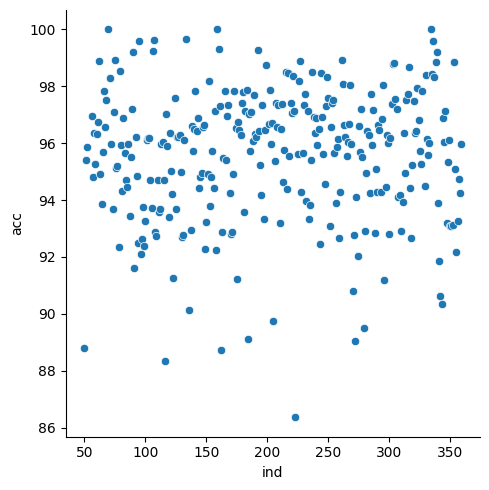

In [30]:
sns.relplot(data=data,x="ind",y="acc")

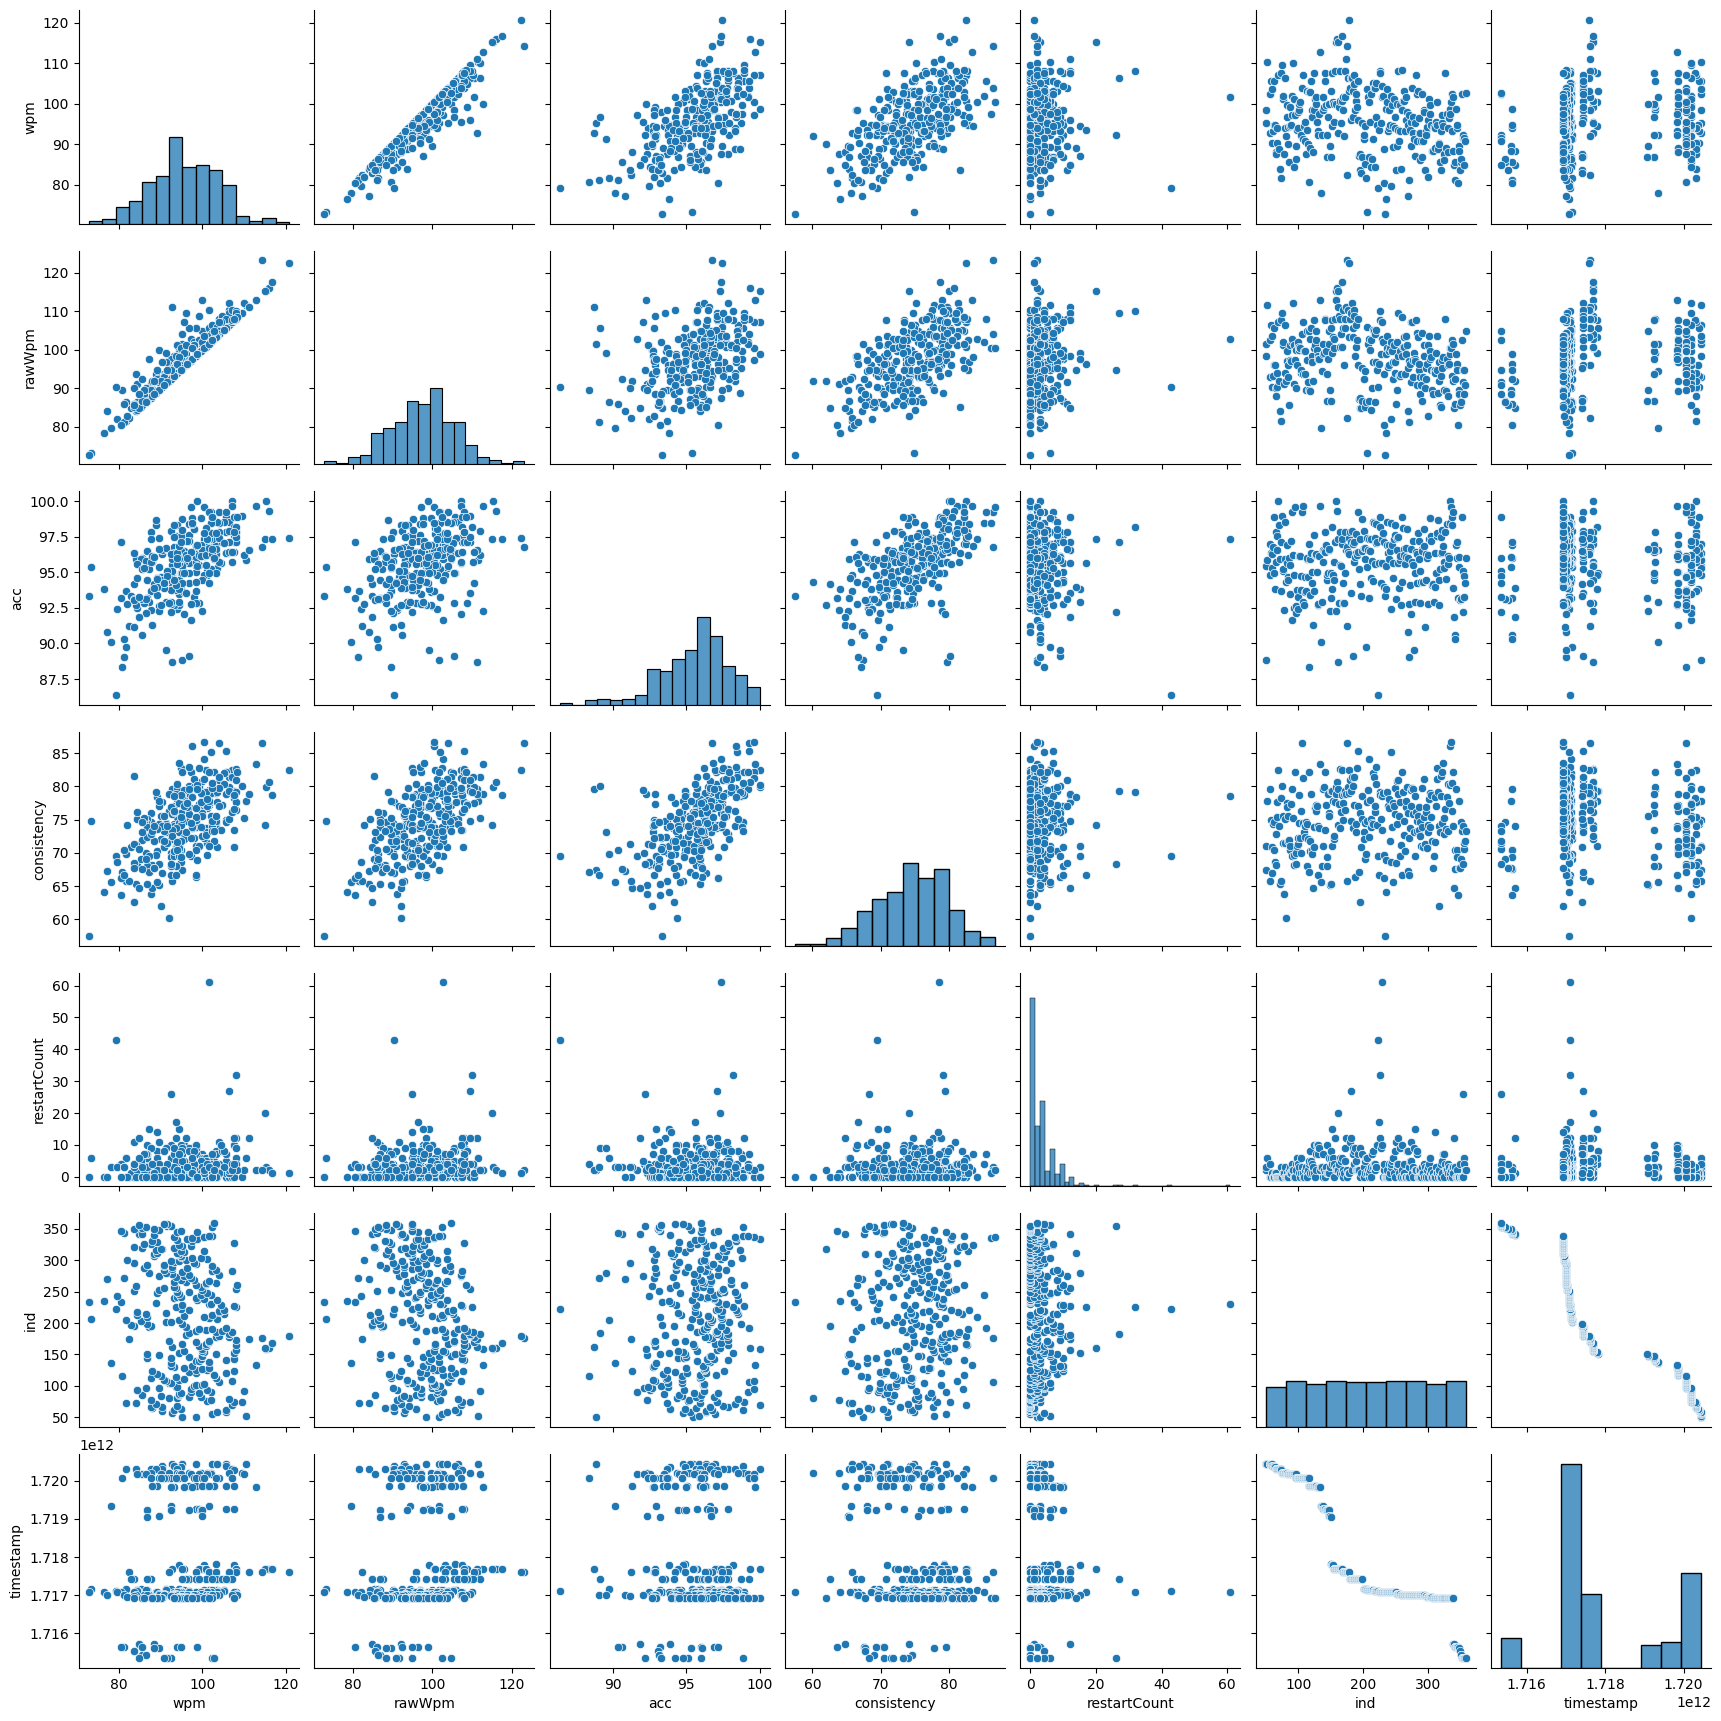

In [31]:
sns.pairplot(data)

<Axes: xlabel='acc', ylabel='wpm'>

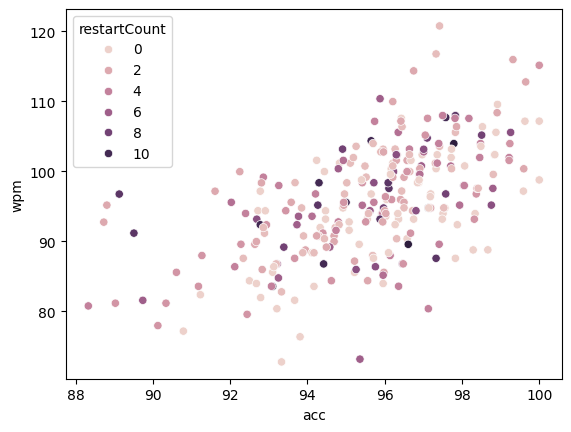

In [32]:
sns.scatterplot(x = data["acc"], y = data["wpm"], hue=data["restartCount"].where(data["restartCount"]<12))

<Axes: xlabel='restartCount', ylabel='wpm'>

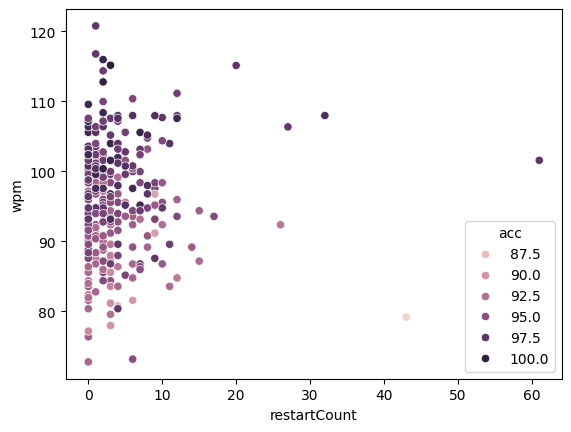

In [33]:
sns.scatterplot(x= data["restartCount"], y=data["wpm"], hue = data["acc"])

<Axes: xlabel='wpm', ylabel='consistency'>

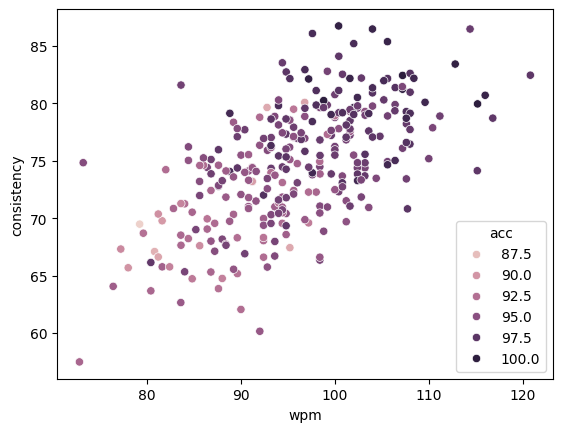

In [34]:
sns.scatterplot(x= data["wpm"], y=data["consistency"], hue = data["acc"])

<Axes: xlabel='restartCount', ylabel='wpm'>

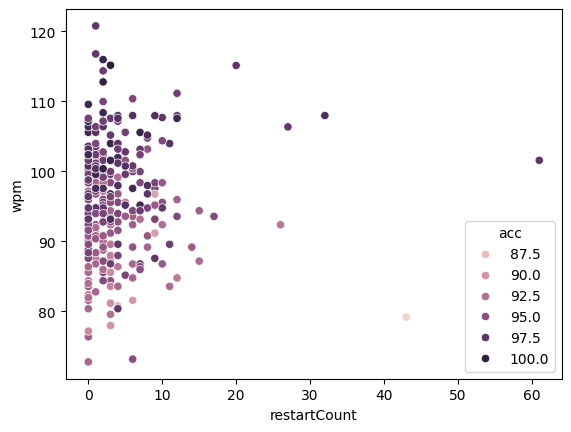

In [35]:
sns.scatterplot(x= data["restartCount"], y=data["wpm"], hue = data["acc"])

## EDA Results and Cause Isolation
 We can see some very distincive trends (or lack thereof) in this data just from the eda. For example, 
higher wpm appears to be correlated with higher accuracy, high accuracy with high consistency (
to be expected) and suprisingly, the number of resets does not seem to affect either accuracy in any significant way. 


However, in the case of accuraccy and consistency, it is important to remember that correlation doesn't always mean direct causation. We can become more convinced of the direct causation (of unknown direction), however, if we remove external variables which may cause the increase of both. In this case, the only variable we have which could do that is Time.
Improvement over time is to be expected, but we can deal with most of it by simply adjusting the data according to the predicted level of improvement. While data that we are using is over a very short time frame, and I don't expect to find a time-wise pattern, I would just like to prove it numerically.

Here I quantify the correlation between time (using index as a measurement of time)
and high wpm/accuracy using linear regression

In [36]:
from sklearn.linear_model import LinearRegression

In [37]:
cModel = LinearRegression()

In [38]:
lin_reg_data = data.copy()
timeWpmModel = LinearRegression()
timeAccModel = LinearRegression()

In [39]:
timeWpmModel.fit(lin_reg_data[["timestamp"]],lin_reg_data[["wpm"]])
wpmScore = timeWpmModel.score(lin_reg_data[["timestamp"]],lin_reg_data[["wpm"]])

timeAccModel.fit(lin_reg_data[["timestamp"]],lin_reg_data[["acc"]])
accScore = timeAccModel.score(lin_reg_data[["timestamp"]],lin_reg_data[["acc"]])


In [40]:
lin_reg_data["pred_wpm"] = timeWpmModel.predict(lin_reg_data[["timestamp"]])
lin_reg_data["pred_acc"] = timeAccModel.predict(lin_reg_data[["timestamp"]])

In [41]:
wpmCoef, wpmIntercept = timeWpmModel.coef_[0][0], timeWpmModel.intercept_[0]
accCoef, accIntercept = timeAccModel.coef_[0][0], timeAccModel.intercept_[0]

In [42]:
print("accuracy linear regression score: "+str(accScore))
print("accuracy linear reg values (coef,int):")
print([accCoef, accIntercept]) 

print("words-per-minute linear regression score: "+str(wpmScore))
print("words-per-minute linear reg values (coef,int):")
print([wpmCoef, wpmIntercept])



accuracy linear regression score: 0.0010658399379046557
accuracy linear reg values (coef,int):
[-5.107873840124689e-11, 183.33445251061985]
words-per-minute linear regression score: 0.019870066044554657
words-per-minute linear reg values (coef,int):
[7.724533811479912e-10, -1231.2432691756935]


### Adjustment and Regression
These regression scores give us sufficient evidence to say that improvement over time did not play any significant role in the correlation. Therefore, we are left with the plausable assumption that tests with higher accuraccy are faster than tests with lower accuraccy in the short run

Next we perform another linear regression to develop an approximate rule to make it easier to think about the relationship between speed and accuracy

In [43]:
wpmaccModel = LinearRegression()
accConsistModel = LinearRegression()

wpmaccModel.fit(lin_reg_data[["acc"]], lin_reg_data[["wpm"]])
accConsistModel.fit(lin_reg_data[["acc"]], lin_reg_data[["consistency"]])

wpmaccScore = wpmaccModel.score(lin_reg_data[["acc"]], lin_reg_data[["wpm"]])
accConsistScore = accConsistModel.score(lin_reg_data[["acc"]],lin_reg_data[["consistency"]])
lin_reg_data["adj_consistency"] = lin_reg_data[['consistency']]-accConsistModel.predict(lin_reg_data[["acc"]])

In [44]:
Coef, Intercept = wpmaccModel.coef_[0][0], wpmaccModel.intercept_[0]
print("linear regression score: "+str(wpmaccScore))
print("linear regression values (coef,int):")
print([Coef, Intercept]) 

Coef, Intercept = accConsistModel.coef_[0][0], accConsistModel.intercept_[0]
print("linear regression score: "+str(accConsistScore))
print("linear regression values (coef,int):")
print([Coef, Intercept]) 

linear regression score: 0.363194161903332
linear regression values (coef,int):
[2.110803887657029, -105.96434186318021]
linear regression score: 0.3604572789071453
linear regression values (coef,int):
[1.3390498260258021, -53.312458887574905]


<Axes: xlabel='adj_consistency', ylabel='wpm'>

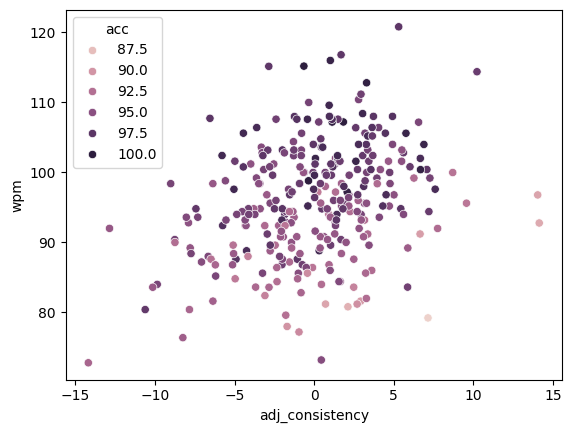

In [45]:
sns.scatterplot(data = lin_reg_data, x = "adj_consistency", y= "wpm", hue = "acc")

<Axes: xlabel='adj_consistency', ylabel='acc'>

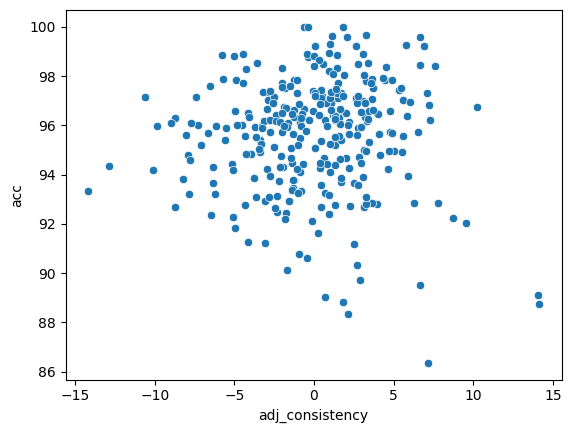

In [46]:
sns.scatterplot(data = lin_reg_data, x = "adj_consistency", y = "acc")

# Results and Comclusion
We started this analysis with 2 questions:
* When looking at short term, would having the "all out"/"as-fast-as-you-can" mindset work better on the scale of individual tests in the short term while screwing up long term progress? Or would it show short term losses as well?

* If I decide mid-way through a test to abandon it and try again with another test, will the natural selection of tests make my recorded wpm unreasonably high and if so, will that negatively affect my long-term growth?

and after analysis here are are our answers:

Q: When looking at short term, would having the "all out"/"as-fast-as-you-can" mindset work better on the scale of individual tests in the short term while screwing up long term progress? Or would it show short term losses as well?
    A: Focusing on accuraccy doesn't only result in long-term improvement, but it also results in improved short run consistency and speed

Q: If I decide mid-way through a test to abandon it and try again with another test, will the natural selection of tests make my recorded wpm unreasonably high and if so, will that negatively affect my long-term growth?
    A: There is no evindence from the given data that restarting the tests results in an effective selection bias.
